## Microsoft Malware Prediction

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. It is really important to find out whether the computer is infected and cure it.

We have a huge dataset of data, where most features are categorical. I think that correct mean encoding should be important. Also the number of columns is quite high so it could be tempting to make some automatical processing for all columns. I personally think that it is important to analyze each variable and it could help to do a better processing.

In this kernel I'll do a detailed EDA, feature engineering and modelling.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10683/logos/thumb76_76.png?t=2018-09-19-16-55-15)

Work is in progress.
- Next Update Probably With Groupby Stats on Selected Columns and Binary hashing...
- Lot of versions Due to Mem Error and Kernel Crashes :(
- [A very Helpful link to Understand Those Data Fields by Microsoft Itself](https://docs.microsoft.com/en-us/windows/privacy/basic-level-windows-diagnostic-events-and-fields-1703)
- [Intresting Updated EDA and Parent Kernel by @ Artgor](https://www.kaggle.com/artgor/is-this-malware-eda-fe-and-baseline-model)


### Some hints for understanding this competition.
(From https://www.kaggle.com/c/microsoft-malware-prediction/discussion/75834, a very important thing to understand.... Thanks!!)
If I am a hacker, and I want to attack window's machine. what I will do?

- I will try to find leaks of some popular software, if one software has many users, then if I attack successfully and I will get many profits(But usually this software has better defense).(This is why some count features are so important).

- I will try to attack some machines that do not have many defenses(especially new software, like is it touch or not？ New products usually have worse defense than old ones since old ones have improved their defenses for a long time. So I will have many chances for new products), (This is why some boolean features are so important.)

In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
#import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error,roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostRegressor
from tqdm import tqdm

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
print(os.listdir("../input"))


['malware-timestamps-2', 'microsoft-malware-prediction', 'malware', 'malware-timestamps']


## Loading data
Let's try loading data in a naive way

In [2]:
#https://www.kaggle.com/theoviel/load-the-totality-of-the-data
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        #'RtpStateBitfield':                                     'float16',
        #'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
#        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        #'PuaMode':                                              'category',
        #'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        #'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        #'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    gc.collect()
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date in the column `fldname` of `df`."
    import re
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attr = attr + ['Hour']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + n] = df[targ_pre + n]*1
    df = reduce_mem_usage(df,False)
    if drop: df.drop(fldname, axis=1, inplace=True)

### AvSigVersion Release Dates

In [3]:
cnt = np.load('../input/malware/ver_updated_defs_count.npy').item()
max(dict(cnt).values())

2000

In [4]:
# IMPORT TIMESTAMP DICTIONARY 
#from Public Datasets and Kernel by Chris
#fix link
datedict = np.load('../input/malware-timestamps/AvSigVersionTimestamps.npy')[()]
datedictOS = np.load('../input/malware-timestamps-2/OSVersionTimestamps.npy')[()]

from collections import OrderedDict
sorted_OS = OrderedDict(sorted(datedictOS.items(), key=lambda x: x[1]))
final_OS  = OrderedDict()
for idx,val in tqdm(enumerate(sorted_OS)):
    final_OS[val[0:]] = (val.split('.')[2], idx)
final_OS_ = OrderedDict(sorted(final_OS.items(), key=lambda x: x[1]))
datedictOS_idx = OrderedDict()
for idx,val in tqdm(enumerate(final_OS_)):
    try:
        datedictOS_idx[val.split('.')[2]+'.'+val.split('.')[3]] = idx
    except:
        datedictOS_idx[val.split('.')[1]+'.'+val.split('.')[2]] = idx
        #print(val)
del final_OS_, final_OS
gc.collect()

324it [00:00, 491306.76it/s]
324it [00:00, 468443.47it/s]


14

In [5]:
all_dates = np.load('../input/malware/all_dates_v2.npy').item()
months={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
temp = pd.read_csv('../input/microsoft-malware-prediction/train.csv', usecols=['AvSigVersion', 'HasDetections'], dtype={'HasDetections':'uint8','AvSigVersion':'str'})

In [6]:
temp['release_dates'] = temp['AvSigVersion'].map(all_dates)
temp['year'] = temp['release_dates'].apply(lambda x: x[7:11])
temp.drop('release_dates', axis=1, inplace=True)
gc.collect()

28

In [7]:
sig_2018 = np.asarray(list(set(temp[(temp['year'] == '2017') | (temp['year'] == '2018')]['AvSigVersion'].values)))
del temp #haha mem hunger
gc.collect()
print(len(sig_2018)) #needs to be improved as we have many in which we couldn't find versions released..

5920


In [8]:
%%time
train = pd.read_csv('../input/microsoft-malware-prediction/train.csv', dtype=dtypes, nrows= 1500000)
train.loc[train[train['OsBuildLab'].isnull()]['OsBuildLab'].index, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'

CPU times: user 28.3 s, sys: 1.59 s, total: 29.9 s
Wall time: 29.9 s


In [9]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
binary_variables = [c for c in train.columns if train[c].nunique() == 2]
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [10]:
# @cpmp https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
import numpy as np 
from numba import jit

@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

def split_sig(sigs):
    """Split the signature given as string into a 4-tuple of integers."""
    return tuple(int(part) for part in sigs.replace('1.2&#x17;3.1144.0','1.273.1144.0').split('.'))

def my_key(item):
    return split_sig(item[0])

items = dict(sorted(datedict.items(), key=my_key))

In [11]:
stats= []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values(['Percentage of missing values', 'Unique_values'], ascending=False).head(15)
del stats_df, stats
gc.collect()

56

In [12]:
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.8 and col not in ['ProductName', 'DefaultBrowsersIdentifier','Firewall', 'IsProtected', 'AVProductsEnabled', 'Census_GenuineStateName']:
        good_cols.remove(col)

train = train[good_cols]
train = reduce_mem_usage(train)
gc.collect()
len(good_cols)

Mem. usage decreased to 220.67 Mb (0.0% reduction)


59

In [13]:
%%time
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}
test = pd.read_csv('../input/microsoft-malware-prediction/test.csv', dtype=test_dtypes, usecols=good_cols[:-1])
del test_dtypes , good_cols
test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804' #17134.1*amd64fre.rs4_release.180410-1804
test.loc[test[test['OsBuildLab'].isnull()]['OsBuildLab'].index, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'
gc.collect()

CPU times: user 2min 11s, sys: 18.7 s, total: 2min 30s
Wall time: 2min 30s


In [14]:
new_map, cnt = {}, 0
for key in tqdm(items.keys()):
    new_map[key] = cnt
    cnt +=1

#Time Sereis EDA Kernel by Chris
#https://www.kaggle.com/cdeotte/time-series-eda-malware-0-64
# FEATURE ENGINEER - WEEK
first = datetime.datetime(2016,1,1); datedict2 = {}
for x in datedict: datedict2[x] = (datedict[x]-first).days//7
train['Week_2016'] = train['AvSigVersion'].map(datedict2)
test['Week_2016'] = test['AvSigVersion'].map(datedict2)

# FEATURE ENGINEER - WEEK
first = datetime.datetime(2018,1,1); datedict2 = {}
for x in datedict: datedict2[x] = (datedict[x]-first).days//7
train['Week_2018'] = train['AvSigVersion'].map(datedict2)
test['Week_2018'] = test['AvSigVersion'].map(datedict2)

train['sort'] = train['AvSigVersion'].map(new_map)
test['sort'] = test['AvSigVersion'].map(new_map)


train['x1'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
train['x2'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[2] +'.'+ x.split('.')[3])
train['temp_x1'] = train['x1'].map(datedictOS_idx)
train['temp_x2'] = train['x2'].map(datedictOS_idx)
train['temp_diffs'] = abs(train['temp_x2'] - train['temp_x1'])

test['x1'] = test['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
test['x2'] = test['Census_OSVersion'].apply(lambda x: x.split('.')[2] +'.'+ x.split('.')[3])
test['temp_x1'] = test['x1'].map(datedictOS_idx)
test['temp_x2'] = test['x2'].map(datedictOS_idx)
test['temp_diffs'] = abs(test['temp_x2'] - test['temp_x1'])

del train['temp_x1'], train['temp_x2'], train['x1'], train['x2'], test['temp_x1'], test['temp_x2'], test['x1'], test['x2']
del first, datedict, datedict2
gc.collect()

100%|██████████| 9622/9622 [00:00<00:00, 1451973.13it/s]


244

We can see several interesting things here:
* PuaMode and Census_ProcessorClass have 99%+ missing values, which means that these columns are useless and should be dropped;
* In DefaultBrowsersIdentifier column 95% values belong to one category, so I think this columns is also useless;
* Census_IsFlightingInternal is strange, but maybe analysis of it will make sense;
* There are 26 columns in total in which one category contains 90% values. I think that these imbalanced columns should be removed from the dataset;
* One more important point is that there are many columns which are considered to be numerical (from this kernel: #https://www.kaggle.com/theoviel/load-the-totality-of-the-data), but I think they are categorical - like CityIdentifier. We'll see more in EDA below;

*  Obtaining height, width, and area of the screen 
Often, screen specifications are given by their diagonal length. The following formulae can be used to find the height (''h''), width (''w'') and area (''A''), where ''r'' stands for ratio, written as a fraction, and ''d'' for diagonal length.
-  h=\frac{d}{\sqrt{r^2+1}} \qquad 
-  w=\frac{r*d}{\sqrt{{r^2}+1}}  \qquad 
-  A=\frac{r*d^2}{{r^2}+1}


I see that all columns except Census_SystemVolumeTotalCapacity are categorical. 
Also there are 3 columns, where most of the values are missing. Let's drop them.

## Data exploration

In [15]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,IeVerIdentifier,SmartScreen,Firewall,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Week_2016,Week_2018,sort,temp_diffs
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,NaN,53447.0,1.0,1.0,29,128035.0,18.0,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,137.0,NaN,1.0,Desktop,2668.0,9124.0,4.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,NaN,628.0,36144.0,0,NaN,0.0,10.0,0,137.0,33.0,8158.0,7.0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,NaN,53447.0,1.0,1.0,93,1482.0,18.0,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,137.0,NaN,1.0,Notebook,2668.0,91656.0,4.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NaN,628.0,57858.0,0,NaN,0.0,8.0,0,112.0,8.0,6196.0,0.0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,NaN,53447.0,1.0,1.0,86,153579.0,18.0,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,137.0,RequireAdmin,1.0,Desktop,4908.0,317701.0,4.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,142.0,52682.0,0,NaN,0.0,3.0,0,136.0,32.0,8048.0,7.0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,NaN,53447.0,1.0,1.0,88,20710.0,NaN,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,137.0,ExistsNotSet,1.0,Desktop,1443.0,275890.0,4.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,NaN,355.0,20050.0,0,NaN,0.0,3.0,1,137.0,32.0,8090.0,10.0
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,NaN,53447.0,1.0,1.0,18,37376.0,NaN,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,137.0,RequireAdmin,1.0,Notebook,1443.0,331929.0,4.0,2500.0,476940.0,HDD,101900.0,6144.0,Portable,14.000000,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.17134.191,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,IS_GENUINE,Retail,0.0,355.0,19844.0,0,0.0,0.0,1.0,1,136.0,32.0,8057.0,9.0


In [16]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'OrganizationIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_OSInstallTypeName',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [17]:
#public kernel (will fix the link)
train.SmartScreen=train.SmartScreen.str.lower()
train.SmartScreen.replace({"promt":"prompt",
                        "promprt":"prompt",
                        "00000000":"0",
                        "enabled":"on",
                        "of":"off" ,
                        "deny":"0" , # just one
                        "requiredadmin":"requireadmin"
                       },inplace=True)
train.SmartScreen = train.SmartScreen.astype("category")

test.SmartScreen = test.SmartScreen.str.lower()
test.SmartScreen.replace({"promt":"prompt",
                        "promprt":"prompt",
                        "00000000":"0",
                        "enabled":"on",
                        "of":"off" ,
                        "deny":"0" , # just one
                        "requiredadmin":"requireadmin"
                       },inplace=True)
test.SmartScreen = test.SmartScreen.astype("category")

In [18]:
# print('grouping combination...')
# gp = train[['CountryIdentifier','OrganizationIdentifier', 'Census_OSInstallTypeName']].groupby(by=['CountryIdentifier','OrganizationIdentifier'], sort=False)[['Census_OSInstallTypeName']].count().reset_index().rename(columns={'Census_OSInstallTypeName':'cnt_cnt_org_os'})
# train = train.merge(gp, on=['CountryIdentifier','OrganizationIdentifier'], how='left')
# del gp
# gc.collect()
# print('grouping combination...')
# gp = test[['CountryIdentifier','OrganizationIdentifier', 'Census_OSInstallTypeName']].groupby(by=['CountryIdentifier','OrganizationIdentifier'], sort=False)[['Census_OSInstallTypeName']].count().reset_index().rename(columns={'Census_OSInstallTypeName':'cnt_cnt_org_os'})
# test = test.merge(gp, on=['CountryIdentifier','OrganizationIdentifier'], how='left')
# del gp
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)
# gc.collect()

# print('grouping combination...')
# gp = train[['CountryIdentifier','OrganizationIdentifier','CityIdentifier', 'Census_OSInstallTypeName']].groupby(['CountryIdentifier','OrganizationIdentifier', 'CityIdentifier'])[['Census_OSInstallTypeName']].count().reset_index().rename(columns={'Census_OSInstallTypeName':'cnt_cnt_org_city_os'})
# train = train.merge(gp, on=['CountryIdentifier','OrganizationIdentifier','CityIdentifier'], how='left')
# del gp
# gc.collect()
# print('grouping combination...')
# gp = test[['CountryIdentifier','OrganizationIdentifier','CityIdentifier', 'Census_OSInstallTypeName']].groupby(['CountryIdentifier','OrganizationIdentifier', 'CityIdentifier'])[['Census_OSInstallTypeName']].count().reset_index().rename(columns={'Census_OSInstallTypeName':'cnt_cnt_org_city_os'})
# test = test.merge(gp, on=['CountryIdentifier','OrganizationIdentifier', 'CityIdentifier'], how='left')
# del gp
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)
# gc.collect()

# print('grouping combination...')
# gp = train[['CountryIdentifier','OrganizationIdentifier','Census_OSBuildNumber', 'Census_OSInstallTypeName']].groupby(['CountryIdentifier','OrganizationIdentifier', 'Census_OSBuildNumber'], sort=False)[['Census_OSInstallTypeName']].count().reset_index().rename(columns={'Census_OSInstallTypeName':'cnt_cnt_org_build_type'})
# train = train.merge(gp, on=['CountryIdentifier','OrganizationIdentifier', 'Census_OSBuildNumber'], how='left')
# del gp
# gc.collect()
# print('grouping combination...')
# gp = test[['CountryIdentifier','OrganizationIdentifier','Census_OSBuildNumber', 'Census_OSInstallTypeName']].groupby(['CountryIdentifier','OrganizationIdentifier', 'Census_OSBuildNumber'], sort=False)[['Census_OSInstallTypeName']].count().reset_index().rename(columns={'Census_OSInstallTypeName':'cnt_cnt_org_build_type'})
# test = test.merge(gp, on=['CountryIdentifier','OrganizationIdentifier', 'Census_OSBuildNumber'], how='left')
# del gp
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)
# gc.collect()


train['fe_avsig_org_freq']        = train[['AvSigVersion','OrganizationIdentifier','OsBuild']].groupby(['AvSigVersion','OrganizationIdentifier'])['OsBuild'].transform('count') / train.shape[0]
train['fe_avsig_cty_freq']        = train[['AvSigVersion','CityIdentifier','OsBuild']].groupby(['AvSigVersion','CityIdentifier'])['OsBuild'].transform('count') / train.shape[0]
train['fe_avsig_gamer_freq']      = train[['AvSigVersion','Wdft_IsGamer', 'OsBuild']].groupby(['AvSigVersion','Wdft_IsGamer'])['OsBuild'].transform('count') / train.shape[0]
train['fe_cpucores_region_freq']  = train[['Census_ProcessorCoreCount','Wdft_RegionIdentifier','OsBuild']].groupby(['Census_ProcessorCoreCount','Wdft_RegionIdentifier'])['OsBuild'].transform('count') / train.shape[0]

test['fe_avsig_org_freq']        = test[['AvSigVersion','OrganizationIdentifier','OsBuild']].groupby(['AvSigVersion','OrganizationIdentifier'])['OsBuild'].transform('count') / test.shape[0]
test['fe_avsig_cty_freq']        = test[['AvSigVersion','CityIdentifier','OsBuild']].groupby(['AvSigVersion','CityIdentifier'])['OsBuild'].transform('count') / test.shape[0]
test['fe_avsig_gamer_freq']      = test[['AvSigVersion','Wdft_IsGamer', 'OsBuild']].groupby(['AvSigVersion','Wdft_IsGamer'])['OsBuild'].transform('count') / test.shape[0]
test['fe_cpucores_region_freq']  = test[['Census_ProcessorCoreCount','Wdft_RegionIdentifier','OsBuild']].groupby(['Census_ProcessorCoreCount','Wdft_RegionIdentifier'])['OsBuild'].transform('count') / test.shape[0]

In [19]:
print(gc.collect())
train['AvSigVersion'] = train['AvSigVersion'].replace(r'[^\.|0-9]','1.273.1826.0')
train['EngineVersion_2'] = train['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')

train['OsBuild_exact'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
train['OsBuild_exact'] = train['OsBuild_exact'].astype('category')

train['AppVersion_1'] = train['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['AppVersion_2'] = train['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['AppVersion_3'] = train['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')

train['AvSigVersion_minor'] = train['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['AvSigVersion_build'] = train['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['AvSigVersion_minor_build'] = train['AvSigVersion'].apply(lambda x: float((x.split('.')[1]) +'.'+(x.split('.')[2]))).astype('float32')

105


In [20]:
test['AvSigVersion'] = test['AvSigVersion'].replace(r'[^\.|0-9]','1.273.1826.0')
test['EngineVersion_2'] = test['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')

test['OsBuild_exact']  =  test['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
test['OsBuild_exact']  = test['OsBuild_exact'].astype('category')

test['AppVersion_1'] = test['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
test['AppVersion_2'] = test['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
test['AppVersion_3'] = test['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')

test['AvSigVersion_minor'] = test['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
test['AvSigVersion_build'] = test['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')
test['AvSigVersion_minor_build'] = test['AvSigVersion'].apply(lambda x: float((x.split('.')[1]) +'.'+(x.split('.')[2]))).astype('float32')

In [21]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

'''IsProtected - 
This is a calculated field derived from the Spynet Report's AV Products field. Returns: 
a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. 
b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. 
c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.''';

train['no_av_at_risk'] = 0
train.loc[train['AVProductsEnabled'].isin([0]) == True, 'no_av_at_risk'] = 1

test['no_av_at_risk'] = 0
test.loc[test['AVProductsEnabled'].isin([0]) == True, 'no_av_at_risk'] = 1

train['not_genuine_user'] = 0
train.loc[train['Census_GenuineStateName'].isin(['IS_GENUINE']) == False, 'not_genuine_user'] = 1

test['not_genuine_user'] = 0
test.loc[test['Census_GenuineStateName'].isin(['IS_GENUINE']) == False, 'not_genuine_user'] = 1

train['AvSigVersion_sum'] = train['AvSigVersion'].apply(lambda x: float(x.split('.')[1]) + float(x.split('.')[2])).astype(int).values
test['AvSigVersion_sum'] = test['AvSigVersion'].apply(lambda x: float(x.split('.')[1]) + float(x.split('.')[2])).astype(int).values

train['AvSigVersion'] = train['AvSigVersion'].astype('category')
test['AvSigVersion'] = test['AvSigVersion'].astype('category')

train['OsBuild_exact'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
test['OsBuild_exact']  =  test['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])

train['OsBuild_exact'] = train['OsBuild_exact'].astype('category')
test['OsBuild_exact']  = test['OsBuild_exact'].astype('category')

top_20 = train['AVProductStatesIdentifier'].value_counts(dropna=False, normalize=True).cumsum().index[:20]
train['magic_4'] = 0
test['magic_4']  = 0
train.loc[train['AVProductStatesIdentifier'].isin(top_20) == True, 'magic_4'] = 1
test.loc[test['AVProductStatesIdentifier'].isin(top_20) == True, 'magic_4']   = 1
del top_20
gc.collect()

Mem. usage decreased to 259.41 Mb (21.6% reduction)
Mem. usage decreased to 1458.97 Mb (20.4% reduction)


98

In [22]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

train['aspect_ratio'] = train['Census_InternalPrimaryDisplayResolutionHorizontal']/ train['Census_InternalPrimaryDisplayResolutionVertical']
test['aspect_ratio']  = test['Census_InternalPrimaryDisplayResolutionHorizontal']/ train['Census_InternalPrimaryDisplayResolutionVertical']

train['primary_drive_c_ratio'] = train['Census_SystemVolumeTotalCapacity']/ train['Census_PrimaryDiskTotalCapacity']
test['primary_drive_c_ratio'] = test['Census_SystemVolumeTotalCapacity']/ test['Census_PrimaryDiskTotalCapacity']

train['non_primary_drive_MB'] = train['Census_PrimaryDiskTotalCapacity'] - train['Census_SystemVolumeTotalCapacity']
test['non_primary_drive_MB']  = test['Census_PrimaryDiskTotalCapacity']  - test['Census_SystemVolumeTotalCapacity']

train['ram_per_processor'] = train['Census_TotalPhysicalRAM']/ train['Census_ProcessorCoreCount']
test['ram_per_processor']  = test['Census_TotalPhysicalRAM']/ test['Census_ProcessorCoreCount']

train['physical_cores'] = train['Census_ProcessorCoreCount'] / 2
test['physical_cores']  = test['Census_ProcessorCoreCount'] / 2

train['hghdec_cnt'] = 0
test['hghdec_cnt'] = 0
train.loc[train['CountryIdentifier'].isin([104,95,214,89,94,59,21,100,85,195,159,57,155,188,33,44,18,88,81,205,141]) == True, 'hghdec_cnt'] = 1
test.loc[test['CountryIdentifier'].isin([104,95,214,89,94,59,21,100,85,195,159,57,155,188,33,44,18,88,81,205,141]) == True, 'hghdec_cnt'] = 1;

train['SmartScreen_dummy'] = 0
test['SmartScreen_dummy'] = 0
train.loc[train['SmartScreen'].isin(['ExistsNotSet', 'RequireAdmin', 'Warn']) == True, 'SmartScreen_dummy'] = 1
test.loc[test['SmartScreen'].isin(['ExistsNotSet', 'RequireAdmin', 'Warn']) == True, 'SmartScreen_dummy'] = 1;

train['one_less_AVproductInstalled'] = train['AVProductsInstalled'] - 1
test['one_less_AVproductInstalled'] = test['AVProductsInstalled'] - 1

Mem. usage decreased to 266.56 Mb (12.7% reduction)
Mem. usage decreased to 1496.42 Mb (11.9% reduction)


In [23]:
def frequency_encoding(variable):
    t = train[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

from tqdm import tqdm_notebook as tqdm
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, -1)).astype(int)
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, -1)).astype(int)
    categorical_columns.remove(variable)

gc.collect()

train.drop(['ProductName', 'DefaultBrowsersIdentifier','Firewall', 'IsProtected', 'AVProductsEnabled', 'Census_GenuineStateName'], inplace=True, axis=1)
test.drop(['ProductName', 'DefaultBrowsersIdentifier','Firewall', 'IsProtected', 'AVProductsEnabled', 'Census_GenuineStateName'], inplace=True, axis=1)
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()


Mem. usage decreased to 270.48 Mb (23.5% reduction)
Mem. usage decreased to 1533.48 Mb (21.5% reduction)


0

### Grouping Census Categories According to the way they were collected

In [24]:
'''
'Microsoft.Windows.Appraiser.General.SystemWimAdd' -> 'Census_IsWIMBootEnabled'
'Census.Hardware'    ->  'Census_ChassisTypeName', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
'Census.Firmware'    ->  'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier',
'Census.Flighting'   ->  'Census_IsFlightingInternal'
'Census.UserDisplay' ->  'Census_InternalPrimaryDiagonalDisplaySizeInInches','Census_InternalPrimaryDisplayResolutionHorizontal',
                         'Census_InternalPrimaryDisplayResolutionVertical',
'Census.Storage'     ->  'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
'Census.Processor'   ->  'Census_ProcessorCoreCount','Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier',
'Census.Battery'     ->  'Census_InternalBatteryType', 'Census_InternalBatteryNumberOfCharges',
'Census.OS'          ->  'Census_OSVersion','Census_OSBranch', 'Census_ActivationChannel'
                         'Census_OSBuildNumber','Census_OSBuildRevision','Census_OSEdition', 'Census_IsSecureBootEnabled'
                         'Census_OSUILocaleIdentifier','Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName'
'''
'''Win10Version	Arch	Year	Critical Updates Last Date	Bypass something	Gain Information	Gain Privileges Total Vul Cnt
1511	x86	2015	08-06-18	4	2	9	38
1511	x86	2016	08-06-18	3	3	7	38
1511	x86	2017	08-06-18	1	3	0	38
1511	x64	2015	08-06-18	4	2	9	40
1511	x64	2016	08-06-18	3	3	7	40
1511	x64	2017	08-06-18	1	3	0	40
1607	x86	2016	08-06-18	1	0	2	9
1607	x86	2017	08-06-18	1	3	0	9
1607	x86	2018	08-06-18	0	0	0	9
1607	x64	2016	08-06-18	1	0	2	13
1607	x64	2017	08-06-18	1	3	0	13
1607	x64	2018	08-06-18	1	1	0	13
1703	x64	2018	15-05-18	1	1	0	419
1709	x64	2018	15-05-18	1	1	0	236
1803	x64	2018	-	1	1	0	131
1809	x64	2018	-	1	0	0	41
''';

In [25]:
train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('category')
test['Census_ProcessorModelIdentifier']  = test['Census_ProcessorModelIdentifier'].astype('category')

In [26]:
top_10 = train['Census_TotalPhysicalRAM'].value_counts(dropna=False, normalize=True).cumsum().index[:10]
train.loc[train['Census_TotalPhysicalRAM'].isin(top_10) == False, 'Census_TotalPhysicalRAM'] = 1024
test.loc[test['Census_TotalPhysicalRAM'].isin(top_10) == False, 'Census_TotalPhysicalRAM']   = 1024
del top_10

In [27]:
train['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = train['Census_InternalPrimaryDiagonalDisplaySizeInInches'].astype('category')
test['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = test['Census_InternalPrimaryDiagonalDisplaySizeInInches'].astype('category')
train['Census_InternalPrimaryDisplayResolutionHorizontal'] = train['Census_InternalPrimaryDisplayResolutionHorizontal'].astype('category')
test['Census_InternalPrimaryDisplayResolutionHorizontal'] = test['Census_InternalPrimaryDisplayResolutionHorizontal'].astype('category')
train['Census_InternalPrimaryDisplayResolutionVertical'] = train['Census_InternalPrimaryDisplayResolutionVertical'].astype('category')
test['Census_InternalPrimaryDisplayResolutionVertical'] = test['Census_InternalPrimaryDisplayResolutionVertical'].astype('category')

In [28]:
train['OsBuild'] = train['OsBuild'].astype('category')
test['OsBuild'] = test['OsBuild'].astype('category')

### Census_InternalBatteryType

In [29]:
# https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all
# grouping battary types by name
def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
    
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].apply(group_battery)
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].apply(group_battery)

### Census_OSEdition

I'll combine similar versions into one.

In [30]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [31]:
train['Census_OSEdition'] = train['Census_OSEdition'].astype(str)
test['Census_OSEdition'] = test['Census_OSEdition'].astype(str)
train['Census_OSEdition'] = train['Census_OSEdition'].apply(rename_edition)
test['Census_OSEdition'] = test['Census_OSEdition'].apply(rename_edition)
train['Census_OSEdition'] = train['Census_OSEdition'].astype('category')
test['Census_OSEdition'] = test['Census_OSEdition'].astype('category')

### Census_OSSkuName
Almost the same as previous variable

In [32]:
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype(str)
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype(str)
train['Census_OSSkuName'] = train['Census_OSSkuName'].apply(rename_edition)
test['Census_OSSkuName'] = test['Census_OSSkuName'].apply(rename_edition)
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype('category')
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype('category')

### Census_OSInstallLanguageIdentifier
Sadly we don't know what mean these numbers.

In [33]:
train['Census_OSInstallLanguageIdentifier'] = train['Census_OSInstallLanguageIdentifier'].astype('category')
test['Census_OSInstallLanguageIdentifier'] = test['Census_OSInstallLanguageIdentifier'].astype('category')

### Census_OSUILocaleIdentifier

In [34]:
train['Census_OSUILocaleIdentifier'] = train['Census_OSUILocaleIdentifier'].astype('category')
test['Census_OSUILocaleIdentifier'] = test['Census_OSUILocaleIdentifier'].astype('category')

###  OSSuite

In [35]:
train['OsSuite'] = train['OsSuite'].astype('category')
test['OsSuite'] = test['OsSuite'].astype('category')

## Feature engineering and transformation

In [36]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_ActivationChannel,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Week_2016,Week_2018,sort,temp_diffs,fe_avsig_org_freq,fe_avsig_cty_freq,fe_avsig_gamer_freq,fe_cpucores_region_freq,EngineVersion_2,OsBuild_exact,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_minor,AvSigVersion_build,AvSigVersion_minor_build,no_av_at_risk,not_genuine_user,AvSigVersion_sum,magic_4,aspect_ratio,primary_drive_c_ratio,non_primary_drive_MB,ram_per_processor,physical_cores,hghdec_cnt,SmartScreen_dummy,one_less_AVproductInstalled
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,78,53447.0,1.0,29,204,1,35.0,171,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Desktop,0,20057,4.0,2340.0,476940.0,HDD,299451.0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,1,4.294967e+09,10.0.17134.165,rs4_release,17134,165,pro,pro,0,26.0,119,UNKNOWN,Retail,NaN,628.0,2557,0,NaN,0.0,10.0,0,137.0,33.0,8160.0,7.0,0.000469,6.675720e-06,0.001474,0.110535,15100,17134.1,18,1807,18075,273,1735,273.25,0,0,2008,1,1.599609,0.627930,177489.0,1024.0,2.0,0,0,0.0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1,53447.0,1.0,93,156,1,119.0,64,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,NaN,Notebook,0,35204,4.0,2404.0,476940.0,HDD,102385.0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,1,1.000000e+00,10.0.17134.1,rs4_release,17134,1,pro,pro,1,8.0,31,UNKNOWN,Retail,NaN,628.0,2019,0,NaN,0.0,8.0,0,112.0,8.0,6196.0,0.0,0.002291,1.066923e-05,0.004719,0.024261,14600,17134.1,13,17134,1,263,48,263.50,0,1,311,1,1.778320,0.214722,374555.0,1024.0,2.0,0,0,0.0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,181,53447.0,1.0,86,786,1,64.0,49,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,137.0,requireadmin,Desktop,11,2,4.0,1972.0,114473.0,SSD,113907.0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,1,4.294967e+09,10.0.17134.165,rs4_release,17134,165,Core,Core,0,7.0,30,FullAuto,OEM:NONSLP,NaN,142.0,188,0,NaN,0.0,3.0,0,136.0,32.0,8048.0,7.0,0.000247,6.556511e-07,0.000809,0.085449,15100,17134.1,18,1807,18075,273,1341,273.25,0,0,1614,1,1.777344,0.995117,566.0,1024.0,2.0,0,0,0.0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,16,53447.0,1.0,88,18,-1,117.0,115,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,137.0,existsnotset,Desktop,2,173,4.0,2272.0,238475.0,UNKNOWN,227116.0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,1,4.294967e+09,10.0.17134.228,rs4_release,17134,228,pro,pro,0,17.0,64,FullAuto,OEM:NONSLP,NaN,355.0,33,0,NaN,0.0,3.0,1,137.0,32.0,8088.0,10.0,NaN,1.531839e-05,0.003271,0.085449,15100,17134.1,18,1807,18075,273,1527,273.25,0,0,1800,1,1.778320,0.952148,11359.0,1024.0,2.0,1,0,0.0
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,12,53447.0,1.0,18,14,-1,277.0,75,17134,768,rs4,17134.1.amd64fre.rs4_

In [37]:
cat_cols = [col for col in train.columns if col not in (['MachineIdentifier', 'Census_SystemVolumeTotalCapacity', 'HasDetections'] + frequency_encoded_variables)  and str(train[col].dtype) == 'category']
len(cat_cols)

31

In [38]:
print(train.shape, test.shape)
assert(train.shape[1] == test.shape[1]+1)

(1500000, 81) (7853253, 80)


In [39]:
train = reduce_mem_usage(train, True)
test  = reduce_mem_usage(test, True)

Mem. usage decreased to 262.12 Mb (4.7% reduction)
Mem. usage decreased to 1496.33 Mb (4.3% reduction)


In [40]:
for col in cat_cols:
    if train[col].nunique() > 2800:
        print(col, train[col].nunique())
        train.drop([col], axis=1, inplace=True)
        test.drop([col], axis=1, inplace=True)
        cat_cols.remove(col)

In [41]:
train = reduce_mem_usage(train, True)
test  = reduce_mem_usage(test, True)
gc.collect()

Mem. usage decreased to 262.12 Mb (0.0% reduction)
Mem. usage decreased to 1496.33 Mb (0.0% reduction)


0

In [42]:
%%time
indexer = {}
for col in cat_cols:
    # print(col)
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(cat_cols):
    
    gc.collect()
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])
    
    train = reduce_mem_usage(train, False)
    test  = reduce_mem_usage(test, False)


CPU times: user 12min 26s, sys: 13min 23s, total: 25min 49s
Wall time: 25min 49s


In [43]:
y = train['HasDetections']
train = train.drop(['HasDetections', 'MachineIdentifier', 'OsPlatformSubRelease'], axis=1)
test = test.drop(['MachineIdentifier', 'OsPlatformSubRelease'], axis=1)
del cnt, sig_2018, all_dates
gc.collect()

14

In [44]:
#no neeed though
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 201.70 Mb (0.0% reduction)
Mem. usage decreased to 1070.99 Mb (0.0% reduction)


## Modelling

In [45]:
n_fold = 3
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)
gc.collect()

0

In [46]:
cat_cols.pop(4)

'OsPlatformSubRelease'

In [47]:
def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    _ = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X, y))):
        
        print('Fold', fold_n, 'started at', time.ctime())
        
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        print('Shapes Are', X_train.shape, X_valid.shape)
        
        if model_type == 'lgb':
            
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)    

            model = lgb.train(params,
                    train_data,
                    num_boost_round= 2500,
                    valid_sets = [train_data, valid_data],
                    verbose_eval= 100,
                    early_stopping_rounds = 200, 
                    feval=eval_auc)
            
            del train_data, valid_data, X_train, train_index, valid_index
            print(gc.collect())
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            
            gc.collect()
            
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        scores.append(roc_auc_score(y_valid, y_pred_valid))
        print('Fold AUC:', roc_auc_score(y_valid, y_pred_valid))
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance(importance_type='gain')
            fold_importance["importance_split"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features importance_type=\'gain\' (avg over folds)');
        
            return _, prediction, feature_importance, model
        return _, prediction
    else:
        return _, prediction

In [48]:
params = {'num_leaves': 40,
         'min_data_in_leaf': 70, 
         'objective':'binary',
         'max_depth': 10,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 17,
         "lambda_l1": 0.1,
         "random_state": 17,
         "verbosity": -1,
         "subsample": 0.7,
         "drop_rate": 0.01}

Fold 0 started at Sun Mar 10 03:46:14 2019
Shapes Are (999999, 78) (500001, 78)
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.609153	training's auc: 0.726231	valid_1's binary_logloss: 0.619437	valid_1's auc: 0.708627
[200]	training's binary_logloss: 0.5971	training's auc: 0.742402	valid_1's binary_logloss: 0.616453	valid_1's auc: 0.712152
[300]	training's binary_logloss: 0.589964	training's auc: 0.752137	valid_1's binary_logloss: 0.615663	valid_1's auc: 0.713123
[400]	training's binary_logloss: 0.584834	training's auc: 0.759107	valid_1's binary_logloss: 0.615248	valid_1's auc: 0.713698
[500]	training's binary_logloss: 0.580651	training's auc: 0.764982	valid_1's binary_logloss: 0.61529	valid_1's auc: 0.71362
[600]	training's binary_logloss: 0.576751	training's auc: 0.770242	valid_1's binary_logloss: 0.615277	valid_1's auc: 0.713598
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.584035	training's auc: 0.760218	val

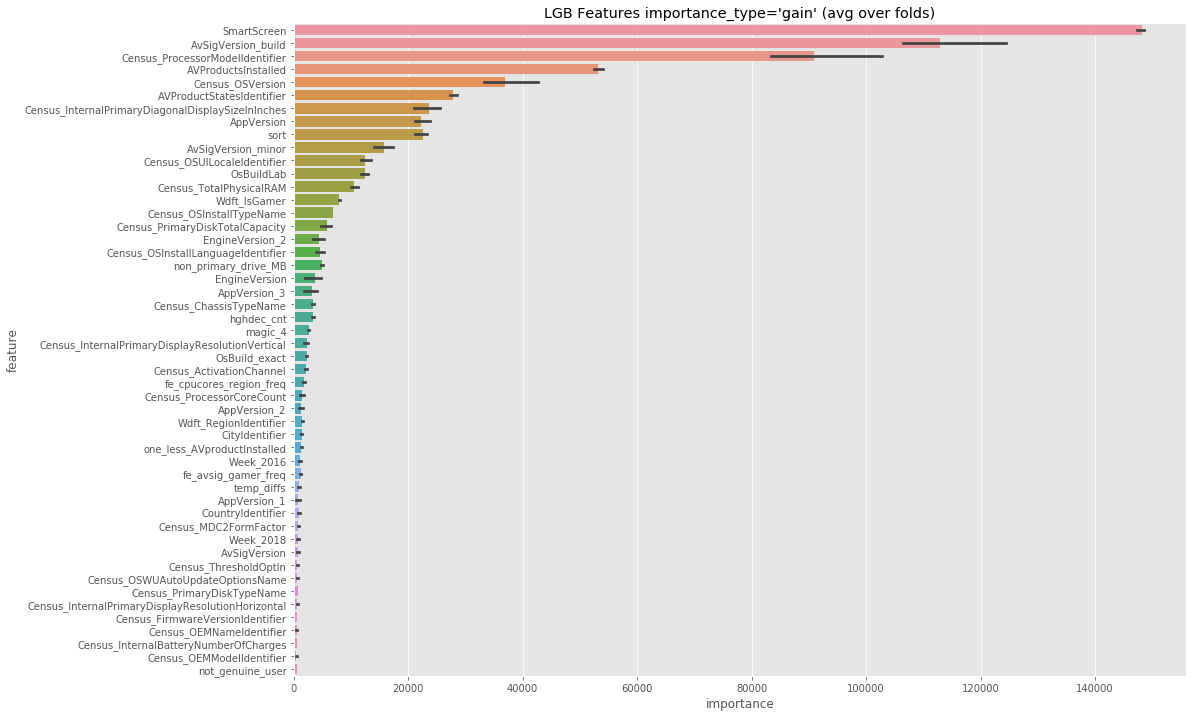

In [49]:
_ , prediction_lgb_1, feats_imp, model_lgb = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [50]:
feats_imp = feats_imp[feats_imp['fold'] == 3]
cm = sns.light_palette("red", as_cmap=True)
feats_imp[['feature','importance','importance_split']].sort_values(by='importance', ascending=False).head(30).\
rename(columns={'importance':'imp_gain', 'importance_split':'imp_split'}).style.background_gradient(cmap = cm)
#this makes a lot more sense now (Imp by Gain) (Thanks tp cpmp and satian)

,feature,imp_gain,imp_split
15,SmartScreen,147372,154
64,AvSigVersion_build,107866,4643
20,Census_ProcessorModelIdentifier,86627.3,4339
4,AVProductsInstalled,52509.4,95
32,Census_OSVersion,35027.4,1944
3,AVProductStatesIdentifier,28511,403
26,Census_InternalPrimaryDiagonalDisplaySizeInInches,24242.3,1152
52,sort,23067.6,171
1,AppVersion,21280,433
63,AvSigVersion_minor,14047.8,59


In [51]:
import joblib
joblib.dump(model_lgb, 'model_lgb.model');

In [52]:
feats_imp.to_csv('feats_imp_max_depth.csv', index=None)
del feats_imp, model_lgb
submission = pd.read_csv('../input/microsoft-malware-prediction/sample_submission.csv')
submission['HasDetections'] = prediction_lgb_1
submission.to_csv('lgb_max_depth.csv', index=False, compression='zip')
del prediction_lgb_1, submission
gc.collect()

10809

In [53]:
train['HasDetections'] = y
train.to_csv('new_train.csv.gz', index=False, compression='zip')
test.to_csv('new_test.csv.gz', index=False, compression='zip')